In [105]:
!pip install -U pandas numpy matplotlib seaborn scikit-learn lightgbm shap joblib optuna

  Using cached numpy-2.3.1-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (62 kB)


In [106]:
# Step 1: Basic packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Modeling
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict,cross_val_score
from sklearn.metrics import roc_auc_score,roc_curve,classification_report,confusion_matrix

# Preprocessing
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# SHAP & Optuna
import optuna
import shap

# Saving model
import joblib

In [107]:
# Upload your kaggle.json key
from google.colab import files
import os
from IPython.display import clear_output

# Step 1: Upload kaggle.json
files.upload()

# Step 2: Clear output so the key is not visible
clear_output()
print("Upload successful and output cleared.")

# Step 3: Save the file to ~/.kaggle with correct permissions
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/ # copy
!chmod 600 ~/.kaggle/kaggle.json # change permissions of a file


Upload successful and output cleared.


In [108]:
# Download the dataset and unzip
!kaggle datasets download -d blastchar/telco-customer-churn -p ./data --unzip

Dataset URL: https://www.kaggle.com/datasets/blastchar/telco-customer-churn
License(s): copyright-authors
  0% 0.00/172k [00:00<?, ?B/s]
100% 172k/172k [00:00<00:00, 348MB/s]


In [109]:
# Load with Inline Indexing
df = pd.read_csv('./data/WA_Fn-UseC_-Telco-Customer-Churn.csv', index_col='customerID')
print(df.shape)
df.head()

(7043, 20)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Exploratory Data Analysis (EDA)

In [110]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null 

In [111]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [112]:
# Check for Missing Values
df.isnull().sum()

,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0
OnlineBackup,0


In [113]:
#  blank or whitespace
blank_counts = (df.applymap(lambda x: isinstance(x,str) and x.strip() =="")).sum()

blank_counts = blank_counts[blank_counts > 0]

print("Columns with blank or whitespace-only strings:")
print(blank_counts)

Columns with blank or whitespace-only strings:
TotalCharges    11
dtype: int64


In [114]:
#Clean up
df['TotalCharges'] = df['TotalCharges'].replace(' ', np.nan)
df['TotalCharges'] = df['TotalCharges'].astype(float)
print("\nMissing values after cleaning:\n")
print(df.isnull().sum())


Missing values after cleaning:

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64


In [115]:
# Drop rows with missing TotalCharges
df = df.dropna(subset=['TotalCharges'])
print("\nMissing values after dropping rows with missing TotalCharges:\n")
print(df.isnull().sum())


Missing values after dropping rows with missing TotalCharges:

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


In [116]:
# Reset index
df.reset_index(drop=True, inplace=True)

In [117]:
# Check Target Variable Distribution
df['Churn'].value_counts(normalize=True)

,proportion
Churn,
No,0.734215
Yes,0.265785


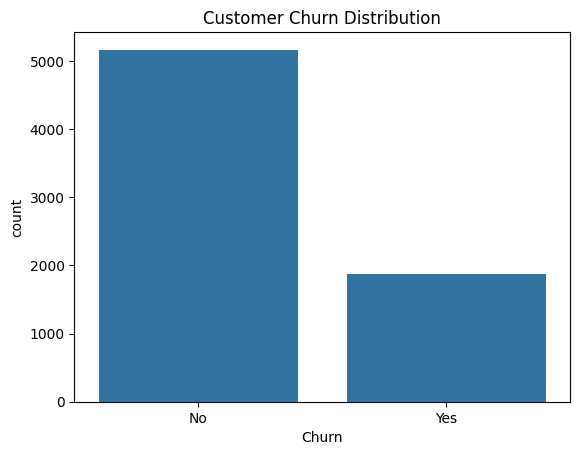

In [118]:
import seaborn as sns
from matplotlib import pyplot as plt

# Create a figure
sns.countplot(x='Churn', data=df)
plt.title('Customer Churn Distribution')
plt.show()

In [119]:
# Convert Target Variable
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

In [120]:
# Confirm conversion
print(df['Churn'].value_counts())

Churn
0    5163
1    1869
Name: count, dtype: int64


In [121]:
# features separation
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.drop('Churn')
categorical_cols = df.select_dtypes(include=['object']).columns

print("Numerical Columns:")
print(numerical_cols)
print("\nCategorical Columns:")
print(categorical_cols)

Numerical Columns:
Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')

Categorical Columns:
Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object')


In [122]:
# Create Pipeline

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Numeric pipeline
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
    ])

# Categorical pipeline
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ])

# Combine
preprocessor = ColumnTransformer([
    ('numeric', numeric_pipeline, numerical_cols),
    ('categorical', categorical_pipeline, categorical_cols)
    ])

Train-Test Split and Full Pipeline

In [123]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict,cross_val_score
import optuna
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score,roc_curve,classification_report,confusion_matrix

# Split data
X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define Optuna objective
def objective(trial):
    # Define hyperparameters to optimize
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50,500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 5.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 5.0),
        'n_jobs': 1,
        'random_state': 42
    }

    #Pipeline
    model = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LGBMClassifier(**params))
    ])

    # Stratified CV
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=skf,n_jobs=-1, scoring='roc_auc')

    return scores.mean()

In [124]:
# Run Study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)


[I 2025-07-17 14:54:11,371] A new study created in memory with name: no-name-b79c1b2a-f04a-40f2-a906-429ab2947415
[I 2025-07-17 14:54:26,770] Trial 0 finished with value: 0.8454023500449441 and parameters: {'n_estimators': 138, 'max_depth': 4, 'learning_rate': 0.28179987906079906, 'num_leaves': 67, 'min_child_samples': 22, 'reg_alpha': 3.475125762372347, 'reg_lambda': 1.3759696054296666}. Best is trial 0 with value: 0.8454023500449441.
[I 2025-07-17 14:54:30,768] Trial 1 finished with value: 0.8435325175929449 and parameters: {'n_estimators': 469, 'max_depth': 6, 'learning_rate': 0.07086753527159914, 'num_leaves': 68, 'min_child_samples': 49, 'reg_alpha': 3.2675203752869955, 'reg_lambda': 1.382121591789759}. Best is trial 0 with value: 0.8454023500449441.
[I 2025-07-17 14:54:33,023] Trial 2 finished with value: 0.8398762622786204 and parameters: {'n_estimators': 450, 'max_depth': 8, 'learning_rate': 0.450541264679463, 'num_leaves': 40, 'min_child_samples': 8, 'reg_alpha': 4.17125174266

In [125]:

# Best results
print("Best AUC:", study.best_value)
print("Best Params:", study.best_params)
best_params = study.best_params

Best AUC: 0.850209333776025
Best Params: {'n_estimators': 352, 'max_depth': 4, 'learning_rate': 0.012159767234644833, 'num_leaves': 49, 'min_child_samples': 18, 'reg_alpha': 1.5338175086687187, 'reg_lambda': 2.043602406459193}


In [126]:
# Train Final Model with Best Parameters (on full X_train)
final_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LGBMClassifier(**best_params))
])
final_model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 1495, number of negative: 4130
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000897 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 668
[LightGBM] [Info] Number of data points in the train set: 5625, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265778 -> initscore=-1.016151
[LightGBM] [Info] Start training from score -1.016151
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('numeric', ...), ('categorical', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [127]:
# Predict on Test Set + Evaluate
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, roc_curve
import matplotlib.pyplot as plt

y_pred = final_model.predict(X_test)
y_pred_proba = final_model.predict_proba(X_test)[:, 1]

auc = roc_auc_score(y_test, y_pred_proba)
print("AUC:", auc)


AUC: 0.8410605111533305


In [128]:
# Print Classification Report and Confusion Matrix (at default threshold 0.5)
y_pred_class = (y_pred_proba >= 0.5).astype(int)
print("Classification Report:\n", classification_report(y_test, y_pred_class))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_class))

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.90      0.87      1033
           1       0.65      0.54      0.59       374

    accuracy                           0.80      1407
   macro avg       0.75      0.72      0.73      1407
weighted avg       0.79      0.80      0.80      1407


Confusion Matrix:
 [[927 106]
 [173 201]]


In [129]:
# Find Best Threshold from ROC
from sklearn.metrics import roc_curve, classification_report, confusion_matrix

# Get predicted probabilities for class 1
y_proba = final_model.predict_proba(X_test)[:, 1]

# Get FPR, TPR, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Choose threshold where (TPR - FPR) is maximized
best_index = (tpr - fpr).argmax()
best_threshold = thresholds[best_index]
print(f"Best Threshold to maximize TPR-FPR: {best_threshold:.2f}")

# Apply the new threshold
y_pred_new = (y_proba >= best_threshold).astype(int)

# Evaluation
print("\nClassification Report (adjusted threshold):")
print(classification_report(y_test, y_pred_new))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_new))


Best Threshold to maximize TPR-FPR: 0.28

Classification Report (adjusted threshold):
              precision    recall  f1-score   support

           0       0.91      0.71      0.80      1033
           1       0.51      0.82      0.62       374

    accuracy                           0.74      1407
   macro avg       0.71      0.76      0.71      1407
weighted avg       0.81      0.74      0.75      1407

Confusion Matrix:
[[735 298]
 [ 69 305]]


In [130]:
X_train.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges'],
      dtype='object')

Final Model + Fit Full Data + Model dump

In [131]:
import joblib
import shap

# Recombine full training data
X_full = pd.concat([X_train, X_test])
y_full = pd.concat([y_train, y_test])

# Rebuild final model pipeline with best parameters
final_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LGBMClassifier(**best_params, random_state=42))
])

# Fit the model on the entire dataset
final_model.fit(X_full, y_full)

# Save the final model pipeline
joblib.dump(final_model, 'final_model_pipeline.pkl')

# Save the best threshold (fixed from earlier run)
with open('best_threshold.txt', 'w') as f:
    f.write("0.33")

print("Final model trained, threshold saved, and pipeline pickled.")


[LightGBM] [Info] Number of positive: 1869, number of negative: 5163
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000988 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 668
[LightGBM] [Info] Number of data points in the train set: 7032, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265785 -> initscore=-1.016114
[LightGBM] [Info] Start training from score -1.016114
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

In [132]:
X_full.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges'],
      dtype='object')

SHAP Explainability on Full Model

In [138]:
import shap
import pandas as pd
import json

# Get transformed data and model
X_full_transformed = final_model.named_steps['preprocessor'].transform(X_full)
model = final_model.named_steps['classifier']

# Get raw one-hot feature names
raw_features = final_model.named_steps['preprocessor'].get_feature_names_out()

# SHAP explainer
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_full_transformed)

# Use class 1 SHAP values if binary classification
shap_matrix = shap_values[1] if isinstance(shap_values, list) else shap_values

# Build SHAP dataframe
shap_df = pd.DataFrame(shap_matrix, columns=raw_features)

# ✅ Group by original column name (everything after '__' but before split value)
# E.g., 'categorical__OnlineSecurity_No internet service' → 'OnlineSecurity'
clean_feature_map = [col.split('__')[-1].split('_')[0] for col in shap_df.columns]

# ✅ Group SHAP values by these clean column names
shap_df.columns = clean_feature_map
print(shap_df.columns)

Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'gender',
       'gender', 'Partner', 'Partner', 'Dependents', 'Dependents',
       'PhoneService', 'PhoneService', 'MultipleLines', 'MultipleLines',
       'MultipleLines', 'InternetService', 'InternetService',
       'InternetService', 'OnlineSecurity', 'OnlineSecurity', 'OnlineSecurity',
       'OnlineBackup', 'OnlineBackup', 'OnlineBackup', 'DeviceProtection',
       'DeviceProtection', 'DeviceProtection', 'TechSupport', 'TechSupport',
       'TechSupport', 'StreamingTV', 'StreamingTV', 'StreamingTV',
       'StreamingMovies', 'StreamingMovies', 'StreamingMovies', 'Contract',
       'Contract', 'Contract', 'PaperlessBilling', 'PaperlessBilling',
       'PaymentMethod', 'PaymentMethod', 'PaymentMethod', 'PaymentMethod'],
      dtype='object')


In [139]:
# ✅ Aggregate (mean SHAP by column name)
top_20_features = shap_df.abs().mean().groupby(level=0).sum().sort_values(ascending=False).head(20)

# ✅ Print and save
print("Top 20 SHAP features (clean names):")
print(top_20_features)

# Save to JSON
with open("top_20_features.json", "w") as f:
    json.dump(top_20_features.to_dict(), f)

Top 20 SHAP features (clean names):
Contract            1.019898
tenure              0.344628
MonthlyCharges      0.245077
OnlineSecurity      0.236534
InternetService     0.192124
TechSupport         0.156470
PaymentMethod       0.154012
PaperlessBilling    0.093976
TotalCharges        0.062497
MultipleLines       0.061105
StreamingMovies     0.060193
OnlineBackup        0.057733
SeniorCitizen       0.032531
StreamingTV         0.027757
Dependents          0.016632
PhoneService        0.015056
gender              0.008865
DeviceProtection    0.001123
Partner             0.000000
dtype: float64


In [140]:
from google.colab import files

# Download model
files.download('final_model_pipeline.pkl')

# Download top 20 SHAP features
files.download('top_20_features.json')

# Download threshold
files.download('best_threshold.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>